# Data visualisation

We start by importing the data

In [1]:
import sklearn
import datetime

import os
import copy
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels as sm
import torch.utils.data as Data

#from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation 
#from tensorflow.keras.layers import MaxPooling2D, Dropout, Conv2DTranspose
#from tensorflow.keras.layers import concatenate, Concatenate
#from tensorflow.keras.models import Model
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras import metrics

#sklearn → model trening
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import accuracy_score, mean_squared_error, r2_score, mean_absolute_error

#sklearn → data treatment
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


#from ILSTM_Soil_model_main import lstm_interprety_soil_moisture as ILSTM
from My_tools import DataFileLoader as DFL # min egen
from My_tools import StudyEstimators as SE
# path definitions

ROOT = "../../"

RESULT_PATH = ROOT + "results/"

DATA_PATH = ROOT + "data/"
PLOT_PATH = RESULT_PATH + "plots/"
TABLE_PATH = RESULT_PATH + "tables/"
OTHER_PATH = RESULT_PATH + "other/"

METADATA_PRELOAD_DATA_PATH = OTHER_PATH + "bin_data/"

DATA_INFO = DATA_PATH + "info/"
DATA_INFO_NIBIO_FILE = DATA_INFO  + "lmt.nibio.csv"
DATA_INFO_FROST_FILE = DATA_INFO + "Frost_stations.csv"
DATA_INFO_NIBIO2FROST_FILE = DATA_INFO + "StationIDInfo.csv"
DATA_FILE_SOIL_STATIONS = DATA_INFO + "'Stasjonsliste jordtemperatur modellering.xlsx'"

DATA_COLLECTION = DATA_PATH + "raw_data/"
DATA_COLLECTION_STAT = DATA_COLLECTION + "Veret paa Aas 2013- 2017/" # pattern -> 'Veret paa Aas 2013- 2017/Veret paa Aas {YYYY}.pdf'
DATA_COLLECTION_TIME = DATA_COLLECTION + "Time 2013- 2023/" # pattern -> Time{YYYY}.xlsx
DATA_COLLECTION_NIBIO = DATA_COLLECTION + "nibio/" # pattern -> weather_data_hour_stID{id}_y{year}.csv
DATA_COLLECTION_MET = DATA_COLLECTION + "MET/" # pattern -> StationTo_{id}_FROM_{FrostID}.csv

# ID definitions
station_names = pd.read_csv(DATA_INFO_NIBIO_FILE,
                          header=0,
                          index_col = "ID")

nibio_id = {
    "Innlandet" : ["11","17","26","27"],
    "Trøndelag" : ["15","57","34","39"],
    "Østfold" : ["37","41","52","118"],
    "Vestfold" : ["30","38","42","50"] # Fjern "50" for å se om bedre resultat
}

Loading data from folders

## Function definitions

In [2]:
def show_plot(data,plot_kwarg):
    """
        plots timeseries, assumes dataframe with a 'Time' columns
    """
    for d in range(len(data)):
        if d not in plot_kwarg:
            plt.plot(data[d].Time, data[d].iloc[:,data[d].columns != "Time"])
        else:
            plt.plot(data[d].Time, data[d].iloc[:,data[d].columns != "Time"],**plot_kwarg[d])
    
    if "xlabel" in plot_kwarg: 
        plt.xlabel = plot_kwarg["xlabel"]
    else:
        plt.xlabel = "Time"
        
    if "ylabel" in plot_kwarg: 
        plt.ylabel = plot_kwarg["ylabel"]
    else:
        plt.ylabel = "celsius degrees ℃"

def stat_model(y_true,y_pred, unscaled = False): 
    """
        Returns a dict with following statitics
        - SSE
        - SST
        - SAE
        - --R^2--
        - bias
        - n

        unscaled: to unscale the relevant metric by |y| (R^2,bias)
    """
    stats = {
        "SSE": ((y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64),
        "SAE": np.abs(y_true - y_pred).sum(axis=0, dtype=np.float64),
        "bias": (y_pred - y_true).sum(axis=0, dtype=np.float64),
        "SST": ((y_true - np.average(y_true, axis=0)) ** 2).sum(axis=0, dtype=np.float64),
        "n": y_true.shape[0]
    }
    return stats

In [3]:
force_load = False
if force_load:
    nibio_data_ungroup = DFL.DataFileLoader(DATA_COLLECTION_NIBIO,r"weather_data_hour_stID(\d{1,3})_y(\d{4}).csv",_iter_key = True)
    nibio_data_ungroup.load_data(names = ["Time","TM","RR","TJM10","TJM20"])
    nibio_data = nibio_data_ungroup.group_layer(nibio_id)

    nibio_data_raw_ungroup = DFL.DataFileLoader(DATA_COLLECTION_NIBIO,r"weather_data_raw_hour_stID(\d{1,3})_y(\d{4}).csv",_iter_key = True)
    nibio_data_raw_ungroup.load_data(names = ["Time","TM","RR","TJM10","TJM20"])
    nibio_data_raw = nibio_data_raw_ungroup.group_layer(nibio_id)

    frost_raw_ungroup = DFL.DataFileLoader(DATA_COLLECTION_MET,r"weather_data_raw_hour_stID(\d{1,3})_y(\d{4}).csv",_iter_key = True)

    def dataframe_merge_func(x,y):
        y.iloc[y.iloc[:,1].notna() & (y.iloc[:,1] <= 0),2] = pd.NA
        x.iloc[0:y.shape[0],2] = y.iloc[0:y.shape[0],2]
        return x

    imputed_nibio_data = nibio_data.combine(nibio_data_raw,merge_func = dataframe_merge_func)
    imputed_nibio_data.dump(METADATA_PRELOAD_DATA_PATH + "weatherdata.bin")

    del nibio_data, nibio_data_raw, frost_raw_ungroup, nibio_data_raw_ungroup, nibio_data_ungroup
else: 
    imputed_nibio_data = DFL.DataFileLoader().load(METADATA_PRELOAD_DATA_PATH + "weatherdata_cleaned.bin")

terskel_data = pd.read_csv(TABLE_PATH + "na_run_count_simp.csv",delimiter=";")
terskel = int(next(t.split(">")[-1] for t in terskel_data.columns if ">" in t))

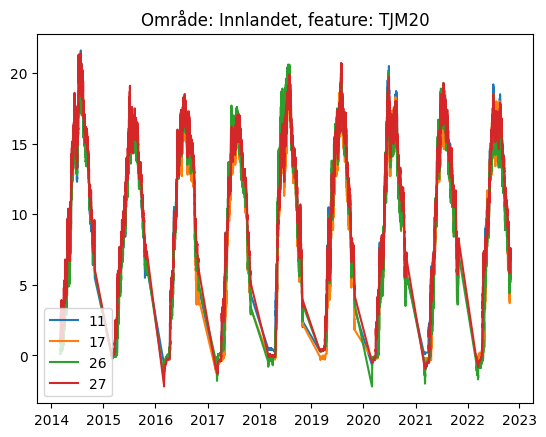

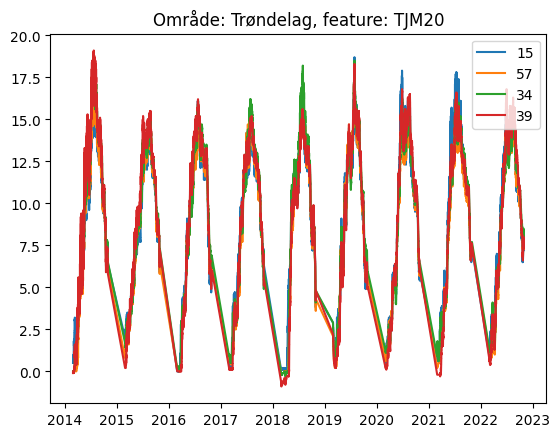

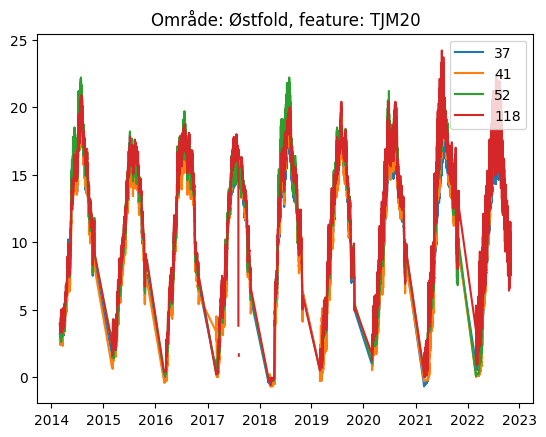

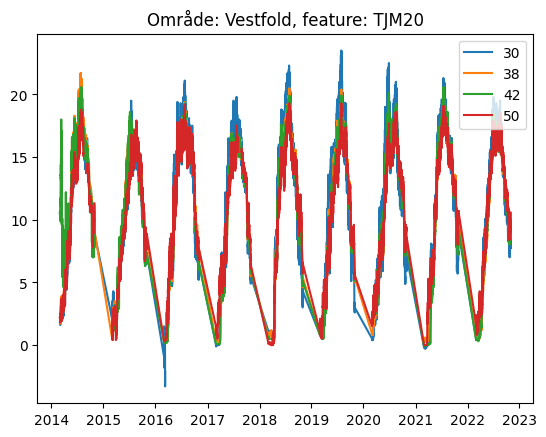

In [4]:
for regi in nibio_id.keys(): 
    show_plot([station.loc[:,["Time","TJM20"]] for station in imputed_nibio_data[regi,:].shave_top_layer().merge_layer(level=1).flatten()],{})
    plt.legend(nibio_id[regi])
    plt.title("Område: {}, feature: {}".format(regi,"TJM20"))
    plt.show()

The data is splitted among two collections of data, one is a pdf and the other is a `.xlsx` format. We start by collecting the data from the hourly data collection.

## Linear regression function 

This function does a transformation of the $m\times n$ matrix (our dataframe) to a $m \times p$ matrix. This can be seen as a kernel trick where we transform the data to a more seperable state to improve prediction. The scema for this model is
$$
    (\vec{F}\circ \mathbf{A})\vec{\beta}=\vec{y}+\vec{\varepsilon}
$$

In [5]:
def all_permute(L):
    """
        makes a list of size 2^len(L)-1 with all combinations
    """
    from itertools import permutations
    final_list = list(L)
    for n in range(2,len(L)+1): 
        final_list.extend(set(permutations(L,n)))
    return final_list

def mediant(x: float,y: float):
    """
        Takes the mediant of two fractions
            a/b + c/d = (a+c)/(b+d)
    """
    frac_x = x.as_integer_ratio()
    frac_y = y.as_integer_ratio()
    comb_xy = (frac_x[0] + frac_y[0],frac_x[1] + frac_y[1])
    return comb_xy[0]/comb_xy[1]

def combine_years(X,Y):
    """
        Combines two dataframes
    """
    if isinstance(X,list) or isinstance(Y,list):
        pass
    if X.index == Y.index:
        return [X,Y]


def find_non_nan_ranges(df):
    """
    Finds the ranges of indexes where rows do not contain NaNs in the DataFrame.
    Assumes there is a 'Time' column with timestamps.

    Args:
        df (pd.DataFrame): Input DataFrame with NaNs.

    Returns:
        list of tuples: List of (start, end) index ranges where rows do not contain NaNs.
    """

    # Initialize variables
    non_nan_ranges = []
    start_idx = None

    # Iterate over rows
    for idx, row in df.items():
        if not(np.isnan(row)):
            # If the row does not contain NaNs
            if start_idx is None:
                # If this is the start of a new range
                start_idx = idx
        else:
            # If the row contains NaNs
            if start_idx is not None:
                # If this is the end of a range
                non_nan_ranges.append((start_idx, idx - 1))
                start_idx = None

    # Check if the last range is still open
    if start_idx is not None:
        non_nan_ranges.append((start_idx, df.index[-1]))

    return non_nan_ranges

### Plauborg regression

Author Plauborg used the above model to predict soil temperature, but used previus time to make the model more time dependent and fourier terms to reflect changes during the year.

In [6]:
def model_traning_testing(datafile,base_model,parameters,feature_target,min_length):
    def calc_stat_from_data(y_true,x_true,model,target,parameters,min_length,s_model_stat = dict()):
        current_stat = stat_model(y_true,model.predict(x_true))
        for metric in current_stat: 
            s_model_stat.setdefault(metric,0)
            s_model_stat[metric] += current_stat[metric]
        return s_model_stat
    
    base_model_stats = {
        "global":{},
        "region":{},
        "station":{}
    }
    def merge_func(left, right):
                if isinstance(left, list) or isinstance(right, list):
                    if not isinstance(left, list):
                        left = [left]
                    if not isinstance(right, list):
                        right = [right]
                    # Concatenate the lists
                    combined_list = left + right
                else:
                    # Create a new list with left and right as elements
                    combined_list = [left, right]
                return combined_list

    global_model = copy.deepcopy(base_model)
    for regi in nibio_id.keys():
        regi_model = copy.deepcopy(base_model)
        for station in nibio_id[regi]:
            s_model = copy.deepcopy(base_model)
            for i in range(2014,2022):
                print(regi,station,i)
                # First we fetch region (regi), all stations (:), then relevant years ("2014":str(i)). Since we only look at one region at the time
                # we remove the root group (shave_top_layer()), then we merge the years (merge_layer(level = 1), level 1 since level 0 would be the stations at this point)
                # then make a list (flatten(), the default handeling is to put leafs in a list)
                data = datafile[regi,station,"2014":str(i)].shave_top_layer().merge_layer(level = 1,merge_func = merge_func).flatten() # looks at all previus years including this year
                if not(isinstance(data,list)):
                    data = [data]
                test = datafile[regi,station,str(i+1)].shave_top_layer().merge_layer(level = 1,merge_func = merge_func).flatten() # looks at the next year
                t = test.infer_objects(copy=False)
                t.loc[t["TM"].isna() | t[feature_target].isna(),["TM",feature_target]] = np.nan
                for d in data: # fitting model with all stations
                    d = d.infer_objects(copy=False)
                    d.loc[d["TM"].isna() | d[feature_target].isna(),["TM",feature_target]] = np.nan
                    trained = False
                    for dt in find_non_nan_ranges(d[feature_target]):
                        if dt[1]-dt[0] < min_length:
                            continue
                        trained = True
                        global_model.fit(d.loc[dt[0]:dt[1],parameters],d.loc[dt[0]:dt[1],feature_target])
                        regi_model.fit(d.loc[dt[0]:dt[1],parameters],d.loc[dt[0]:dt[1],feature_target]) # regions model
                        s_model.fit(d.loc[dt[0]:dt[1],parameters],d.loc[dt[0]:dt[1],feature_target]) # Station model
                if not(trained):
                    continue
                for dt in find_non_nan_ranges(t[feature_target]): 
                    if dt[1]-dt[0] < min_length:
                        continue
                    base_model_stats["global"] = calc_stat_from_data(t.loc[dt[0]:dt[1],feature_target].to_numpy(),t.loc[dt[0]:dt[1],parameters],global_model,feature_target,parameters,min_length,s_model_stat=base_model_stats["global"])
                    base_model_stats["region"][regi] = calc_stat_from_data(t.loc[dt[0]:dt[1],feature_target].to_numpy(),t.loc[dt[0]:dt[1],parameters],regi_model,feature_target,parameters,min_length,s_model_stat=base_model_stats["region"].setdefault(regi,dict()))
                    base_model_stats["station"][station] = calc_stat_from_data(t.loc[dt[0]:dt[1],feature_target].to_numpy(),t.loc[dt[0]:dt[1],parameters],s_model,feature_target,parameters,min_length,s_model_stat=base_model_stats["station"].setdefault(station,dict()))
            base_model_stats["station"][station]["model"] = s_model
        base_model_stats["region"][regi]["model"] = regi_model
    base_model_stats["global"]["model"] = global_model
    return base_model_stats


In [9]:
parameters = ["Time","TM"]
feature_target = "TJM20"
min_length = 24 # minimum number of rows used in sequense

base_model = LinearRegression()

def time2float(x):
    if "Time" in x.columns:
        x["Time"] = x["Time"].transform({"Time":lambda x: x.day_of_year*24 + x.hour})
    return x

adapted_data = imputed_nibio_data.data_transform(time2float)

lin_reg_stats = model_traning_testing(
    datafile = adapted_data,
    base_model = base_model,
    parameters = parameters,
    feature_target = feature_target,
    min_length = min_length
)

Innlandet 11 2014
Innlandet 11 2015
Innlandet 11 2016
Innlandet 11 2017
Innlandet 11 2018
Innlandet 11 2019
Innlandet 11 2020
Innlandet 11 2021
Innlandet 17 2014
Innlandet 17 2015
Innlandet 17 2016
Innlandet 17 2017
Innlandet 17 2018
Innlandet 17 2019
Innlandet 17 2020
Innlandet 17 2021
Innlandet 26 2014
Innlandet 26 2015
Innlandet 26 2016
Innlandet 26 2017
Innlandet 26 2018
Innlandet 26 2019
Innlandet 26 2020
Innlandet 26 2021
Innlandet 27 2014
Innlandet 27 2015
Innlandet 27 2016
Innlandet 27 2017
Innlandet 27 2018
Innlandet 27 2019
Innlandet 27 2020
Innlandet 27 2021
Trøndelag 15 2014
Trøndelag 15 2015
Trøndelag 15 2016
Trøndelag 15 2017
Trøndelag 15 2018
Trøndelag 15 2019
Trøndelag 15 2020
Trøndelag 15 2021
Trøndelag 57 2014
Trøndelag 57 2015
Trøndelag 57 2016
Trøndelag 57 2017
Trøndelag 57 2018
Trøndelag 57 2019
Trøndelag 57 2020
Trøndelag 57 2021
Trøndelag 34 2014
Trøndelag 34 2015
Trøndelag 34 2016
Trøndelag 34 2017
Trøndelag 34 2018
Trøndelag 34 2019
Trøndelag 34 2020
Trøndelag 

In [ ]:
pickle.dump(lin_reg_stats,f := open(METADATA_PRELOAD_DATA_PATH + "lin_stat.bin","wb"))
f.close()

In [ ]:
parameters = ["Time","TM"]
feature_target = "TJM20"
min_length = 24 # minimum number of rows used in sequense

base_model = SE.PlauborgRegresson()

Plauborg_stats = model_traning_testing(
    datafile = imputed_nibio_data,
    base_model = base_model,
    parameters = parameters,
    feature_target = feature_target,
    min_length = min_length
)

In [8]:
pickle.dump(Plauborg_stats,f := open(METADATA_PRELOAD_DATA_PATH + "Plauborg_stat.bin","wb"))
f.close()

{'global': {'SSE': 195247024928483.7, 'SAE': 923177033.4841534, 'bias': 253483062.24657932, 'SST': 15368207.893614834, 'n': 709773, 'model': PlauborgRegresson()}, 'region': {'Innlandet': {'SSE': 4158964869.0799494, 'SAE': 3552237.6837379197, 'bias': 2780489.919582338, 'SST': 3784624.918825498, 'n': 159566, 'model': PlauborgRegresson()}, 'Trøndelag': {'SSE': 15256131490.660452, 'SAE': 6075545.71141855, 'bias': 5300429.761878111, 'SST': 3387059.1750152856, 'n': 186534, 'model': PlauborgRegresson()}, 'Østfold': {'SSE': 2025387885306.4634, 'SAE': 82755248.39910777, 'bias': 40018287.74244438, 'SST': 4198267.547011138, 'n': 183055, 'model': PlauborgRegresson()}, 'Vestfold': {'SSE': 193202221946817.5, 'SAE': 830794001.6898893, 'bias': 205383854.82267457, 'SST': 3998256.2527629077, 'n': 180618, 'model': PlauborgRegresson()}}, 'station': {'11': {'SSE': 4151797171.4913616, 'SAE': 3054582.735521147, 'bias': 2902165.333960543, 'SST': 1086390.906655619, 'n': 44232, 'model': PlauborgRegresson()}, '1

### Rankin regression

This regression tries to solve the following integreal using an FDM.

$$
T = \int_{t_0}^{t_{max}} \frac{1}{C_{A}} \frac{\partial}{\partial z}\left(K_T \frac{\partial T}{\partial z}\right) dt
$$

Where T is temperature, z is depth, and t is time. In this study we will approximate several thing including

- $K_T / C_A \approx \partial_tT/\partial^2_zT$
- $f_S \approx -0.5\ln(T^{t+1}/T_*^{t})/D_t$

best_rankin = {
    "Score":np.inf,
    "mse":0,
    "r2":0,
    "year":0,
    "model":None
}

worst_rankin = {
    "Score":-np.inf,
    "mse":0,
    "r2":0,
    "year":0,
    "model":None,
}

base_model = SE.RankinRegresson()

for regi in nibio_id.keys():
    for i in range(2014,2022):
        # First we fetch region (regi), all stations (:), then relevant years ("2014":str(i)). Since we only look at one region at the time
        # we remove the root group (shave_top_layer()), then we merge the years (merge_layer(level = 1), level 1 since level 0 would be the stations at this point)
        # then make a list (flatten(), the default handeling is to put leafs in a list)
        
        data = imputed_nibio_data[regi,:,"2014":str(i)].shave_top_layer().merge_layer(level = 1).flatten() # looks at all previus years including this year
        test = imputed_nibio_data[regi,:,str(i+1)].shave_top_layer().merge_layer(level = 1).flatten() # looks at the next year

        data = [d.infer_objects(copy=False).fillna(0) for d in data] # Removes nan in a quick manner
        test = [d.infer_objects(copy=False).fillna(0) for d in test] # but will be reviced.
        
        model = copy.deepcopy(base_model)
        overall_r2 = None
        for d,t in zip(data,test): # fitting model with all stations
            model.fit(d,d.loc[:,["TJM20"]]) # regions model
            s_model = copy.deepcopy(base_model).fit(d,d.loc[:,["TJM20"]]) # Station model
            if overall_r2 is not None:
                overall_r2 = 1-mediant(1-overall_r2, 1-r2_score(t["TJM20"].to_numpy(),s_model.predict(t)))
            else:
                overall_r2 = r2_score(t["TJM20"].to_numpy(),s_model.predict(t))
            
            
        print(regi,"from year 2014 to year",i,":\n",
              "\tMSE:",
              mae := [mean_squared_error(t["TJM20"].to_numpy(),model.predict(t)) for t in test],
              "\n\tR2:",
              r2 := [r2_score(t["TJM20"].to_numpy(),model.predict(t)) for t in test])
        score = max(m/r for m,r in zip(mae,r2))
        model_info = {
                "Score":score, 
                "mse":mae, 
                "r2": r2,
                "r2_spes": overall_r2,
                "year_max": i, 
                "region": regi, 
                "model": model
            }
        if score < best_rankin["Score"]:
            best_rankin = model_info
        elif score > worst_rankin["Score"]:
            worst_rankin = model_info

print(best_rankin)
print(worst_rankin)

## LSTM

This is a base model for testing ILSTM in the next section.

In [ ]:
parameters = ["Time","TM"]
feature_target = "TJM20"
min_length = 200 # minimum number of rows used in sequense
search_area = {"input_shape":[12*n for n in range(2,14)],"lstm_units":[2**k for k in range(10,20)],"epochs":[2*n for n in range(25,50)]}
base_model = GridSearchCV(SE.KerasBiLSTM(),param_grid=search_area,n_jobs = -1)

KerasBiLSTM_stats = model_traning_testing(
    datafile = imputed_nibio_data,
    base_model = base_model,
    parameters = parameters,
    feature_target = feature_target,
    min_length = min_length
)

Innlandet 11 2014


2024-04-14 16:59:54.393094: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 16:59:54.393818: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 16:59:54.394476: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 16:59:54.431434: I tensorflow/core/platform/cpu_featu

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50


/home/matsho/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/matsho/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/matsho/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `

In [ ]:
pickle.dump(KerasBiLSTM_stats,f := open(METADATA_PRELOAD_DATA_PATH + "KerasBiLSTM_stat.bin","wb"))
f.close()

In [ ]:
all_data_daily = data_t.set_index("Time").resample("D").mean().dropna().reset_index()

p_data = F_plauborg(all_data_daily)
ridge = LinearRegression().fit(p_data[50:], all_data_daily.iloc[50:,[-1]])
y_pred = ridge.predict(p_data[50:])
display = PredictionErrorDisplay(y_true=all_data_daily.iloc[50:,[-1]], y_pred=y_pred)
display.plot(kind = "actual_vs_predicted",scatter_kwargs = {
    "c": np.linspace(0,1,num = all_data_daily.iloc[50:,[-1]].shape[0]),
    "color": None
})
plt.show()

all_data_daily = all_data_daily.reset_index().loc[50:]

Y = pd.DataFrame(
    zip(all_data_daily["Time"].to_numpy().tolist(), y_pred.flatten()),
    columns=["Time","Y_pred"])

show_plot([all_data_daily.loc[:,["Time","TJM20"]],Y,all_data_daily.loc[:,["Time","RR"]]],{1:{"alpha":0.5}} )
plt.legend(["Y","Y_pred"])
plt.ylim(-5,25)
plt.ylabel("℃")
plt.show()

# ILSTM training

Here we will be training a version of LSTM

In [ ]:
import copy

def ILSTM_train(raw_data, target_label,total_epoch = 50,hidden_size=16,lerningrate=1e-3, lead_time=1, seq_length=24, batch_size=16):
    data,scaler,scaler1 = ILSTM.nibio_data_transform(raw_data, target_label)
    data = scaler1.transform(data)

    # TODO: Generate the tensor for lstm model

    [data_x, data_y,data_z] = ILSTM.LSTMDataGenerator(data, lead_time, batch_size, seq_length)

       # concat all variables.
    # TODO: Flexible valid split
    data_train_x=data_x[:int((data_x.shape[0])-400*24)]
    data_train_y = data_y[:int(data_x.shape[0]-400*24)]

    train_data = Data.TensorDataset(data_train_x, data_train_y)
    train_loader = Data.DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    data_valid_x=data_x[int(data_x.shape[0]-400*24):int(data_x.shape[0]-365*24)] # -> trener 35 dager
    data_valid_y=data_y[int(data_x.shape[0]-400*24):int(data_x.shape[0]-365*24)] # -> tester 35 dager
    data_test_x=data_x[int(data_x.shape[0]-365*24):int(1.0 * data_x.shape[0])] # -> validerer på resterende
    data_testd_z=data_z[int(data_x.shape[0]-365*24):int(1.0 * data_x.shape[0])] # -> stat på rest

    # TODO: Flexible input shapes and optimizer
    # IMVTensorLSTM,IMVFullLSTM
    model = ILSTM.ILSTM_SV(data_x.shape[2],data_x.shape[1], 1, hidden_size).cuda()
    # TODO: Trian LSTM based on the training and validation sets
    model,predicor_import,temporal_import=ILSTM.train_lstm(model,lerningrate,total_epoch,train_loader,data_valid_x,data_valid_y,"./saved_models/lstm_1d.h5")

    # TODO: Create predictions based on the test sets
    pred, mulit_FV_aten, predicor_import,temporal_import = ILSTM.create_predictions(model, data_test_x,scaler)
    # TODO: Computer score of R2 and RMSE

    data_testd_z=data_testd_z.reshape(-1,1)
    data_testd_z=data_testd_z.cpu()
    data_testd_z=data_testd_z.detach().numpy()
    # Unnormalize
    data_testd_z=scaler.inverse_transform(data_testd_z)
    ILSTM.compute_rmse_r2(data_testd_z,pred,modelname)

    print(pred)

    return pred
    

Need to transform the data first to fit the model.

In [ ]:
def datetime2string(x):
    x["Time"] = x["Time"].apply(lambda y: y.strftime("%Y-%m-%d %X"))
    return x
station_data = imputed_nibio_data.data_transform(datetime2string).merge_layer(level = 1)

In [ ]:
ILSTM_train(copy.deepcopy(station_data["11"]),"TJM20",batch_size = 8,total_epoch = 20)